**모델 저장과 재사용** 

책 제목(Title)을 활용하여 책 가격 예측 <--- 회귀 문제
FNN


In [ ]:
# 한글 깨짐
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기
df_temp = pd.read_csv('/content/book.csv', encoding='euc-kr')
# df_1 = pd.read_csv('./book.csv', encoding='euc-kr')

# NaN 값과 빈 문자열 제거
df_1 = df_temp.dropna(subset=['Title'])
df_1 = df_1[df_1['Title'].str.strip() != '']

# 한국어 타이틀 레코드만 가져옴
df = df_1[df_1['Title'].str.contains('[가-힣]', regex=True)]

# 상위 5개 행 확인
# print(df.head())


In [ ]:
print(len(df_1))
print(len(df))

25082
23448


In [ ]:
print(df['Price'].dtypes)

object


In [3]:
# 분석을 위해서 필수적으로 변환 해야 하는 컬럼

# 변환 전 데이터 확인
# print(df['Pdate'].head())
# print(df['Price'].dtypes)

# price  object => 수치형
df['Price'] = pd.to_numeric(df['Price'].str.replace('[^\d.]', ''), errors='coerce')

# 'Pdate' 컬럼을 날짜 타입으로 변환 (한국어 날짜 형식에 맞춤)
df['Pdate'] = pd.to_datetime(df['Pdate'], format='%Y년 %m월 %d일', errors='coerce')


<ipython-input-3-1fae9875f656>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Price'] = pd.to_numeric(df['Price'].str.replace('[^\d.]', ''), errors='coerce')
<ipython-input-3-1fae9875f656>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pdate'] = pd.to_datetime(df['Pdate'], format='%Y년 %m월 %d일', errors='coerce')


In [4]:
# 변환 후 데이터 타입 확인
# print(df['Pdate'].head())
print(df['Price'].dtypes)

float64


In [5]:
# 결측치 제거 (제목과 가격이 있는 행만 유지)
df.dropna(subset=['Title', 'Price'], inplace=True)


<ipython-input-5-9b67674be015>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['Title', 'Price'], inplace=True)


In [6]:
##################################################################
############## FNN
##################################################################

import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split



In [7]:
# 데이터셋 분리: 입력과 타겟
X = df['Title']
y = df['Price'].astype(float)

In [8]:
# 텍스트 토큰화 및 시퀀스 변환
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)


In [9]:
# 패딩으로 시퀀스 길이 맞추기
X_pad = pad_sequences(X_seq, maxlen=100)


In [10]:
# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)


In [11]:
# 모델 구축
model_fnn = Sequential()
model_fnn.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=100))
model_fnn.add(Flatten())
model_fnn.add(Dense(64, activation='relu'))
model_fnn.add(Dense(1, activation='linear'))


In [16]:
model_fnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          116224    
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 64)                819264    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 935553 (3.57 MB)
Trainable params: 935553 (3.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# 모델 컴파일
model_fnn.compile(optimizer='adam', loss='mean_squared_error')


In [13]:
# 모델 훈련
model_fnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
11/11 [==============================] - 1s 39ms/step - loss: 446891.5938 - val_loss: 441361.6250
Epoch 2/10
11/11 [==============================] - 0s 26ms/step - loss: 417540.5000 - val_loss: 400610.7812
Epoch 3/10
11/11 [==============================] - 0s 25ms/step - loss: 365353.0938 - val_loss: 336108.4062
Epoch 4/10
11/11 [==============================] - 0s 25ms/step - loss: 291095.5000 - val_loss: 250336.7656
Epoch 5/10
11/11 [==============================] - 0s 26ms/step - loss: 203409.3281 - val_loss: 162612.6406
Epoch 6/10
11/11 [==============================] - 0s 23ms/step - loss: 127263.1328 - val_loss: 105476.0703
Epoch 7/10
11/11 [==============================] - 0s 23ms/step - loss: 93383.4922 - val_loss: 92823.3516
Epoch 8/10
11/11 [==============================] - 0s 24ms/step - loss: 90362.8438 - val_loss: 93462.9453
Epoch 9/10
11/11 [==============================] - 0s 23ms/step - loss: 89842.0625 - val_loss: 91394.4219
Epoch 10/10
11/11 [======

In [14]:
# 예측 및 평가

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 모델 평가: Keras에서 반환하는 손실값
loss = model_fnn.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')

# 예측값 생성
y_pred = model_fnn.predict(X_test).flatten()

# MSE 계산
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# RMSE 계산
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# MAE 계산
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# R² 계산
r2 = r2_score(y_test, y_pred)
print(f'R-squared (R²): {r2}')

Test Loss: 73301.2890625
4/4 [==============================] - 0s 5ms/step
Mean Squared Error (MSE): 73301.28512980024
Root Mean Squared Error (RMSE): 270.74210077082626
Mean Absolute Error (MAE): 236.01592351740058
R-squared (R²): 0.04946600708498583


In [15]:
##############################  모델 저장
model_fnn.save('model_fnn.h5')  # H5 파일 포맷으로 저장

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
##############################  모델 불러오기
from tensorflow.keras.models import load_model

# 저장된 모델 파일 로드
model_saved = load_model('model_fnn.h5')

In [24]:
### 불러온 모델을 통한 가격 예측
titles = ['실용 여행', '인공지능 가이드 ']  # 새로운 책 제목 입력을 위한 리스트
new_data = pd.DataFrame({'title': titles})


In [25]:
# 텍스트 토큰화와 시퀀스 변환
tokenizer = Tokenizer()
tokenizer.fit_on_texts(new_data['title'])  # 'title' 열에 대해 fit_on_texts 실행
newX_seq = tokenizer.texts_to_sequences(new_data['title'])  # 'title' 열에 대해 texts_to_sequences 실행


In [26]:
# 패딩으로 시퀀스 길이 맞추기
newX_pad = pad_sequences(newX_seq, maxlen=100)

In [27]:
# 호출한 모델을 통한 책 예측
predictions = model_saved.predict(newX_pad)

# 예측된 책 가격을 출력.
# print(predictions)

1/1 [==============================] - 0s 63ms/step


In [28]:
# 책 제목과 예측값 출력
for title, prediction in zip(titles, predictions):
    print(f"'{title}-' 예측 가격: {prediction[0]}")

'실용 여행-' 예측 가격: 608.2285766601562
'인공지능 가이드 -' 예측 가격: 607.5814819335938


In [29]:
##################################
############ .h5 파일 내용 확인하기
##################################
import h5py

# .h5 파일 열기
file = h5py.File('model_fnn.h5', 'r')

# 파일 내의 모든 데이터셋과 그룹 확인
def print_datasets(name, obj):
    if isinstance(obj, h5py.Dataset):
        print(name)

file.visititems(print_datasets)

# 파일 닫기
file.close()


model_weights/dense/dense/bias:0
model_weights/dense/dense/kernel:0
model_weights/dense_1/dense_1/bias:0
model_weights/dense_1/dense_1/kernel:0
model_weights/embedding/embedding/embeddings:0
optimizer_weights/Adam/m/dense/bias:0
optimizer_weights/Adam/m/dense/kernel:0
optimizer_weights/Adam/m/dense_1/bias:0
optimizer_weights/Adam/m/dense_1/kernel:0
optimizer_weights/Adam/m/embedding/embeddings:0
optimizer_weights/Adam/v/dense/bias:0
optimizer_weights/Adam/v/dense/kernel:0
optimizer_weights/Adam/v/dense_1/bias:0
optimizer_weights/Adam/v/dense_1/kernel:0
optimizer_weights/Adam/v/embedding/embeddings:0
optimizer_weights/iteration:0


In [32]:
############# 데이터 셋 내용 확인
import h5py
# .h5 파일 열기
file = h5py.File('model_fnn.h5', 'r')

# 데이터셋
dataset = file['optimizer_weights/Adam/v/embedding/embeddings:0']

# 데이터 읽기
data = dataset[:]

# 파일 닫기
file.close()

# 데이터 출력
print(data)


[[1.2167363e+07 1.0124040e+07 1.0213278e+07 ... 1.1470253e+07
  1.0471375e+07 1.1936756e+07]
 [2.5651761e+02 3.0458826e+02 2.8525351e+02 ... 2.9280621e+02
  3.1853583e+02 9.8456650e+01]
 [8.5085587e+01 7.9904930e+01 8.1240524e+01 ... 8.9840042e+01
  8.5998825e+01 5.8294479e+01]
 ...
 [6.0301840e-01 4.7128120e-01 5.2602881e-01 ... 3.9549163e-01
  5.9750903e-01 5.0909263e-01]
 [4.9830690e-01 1.0200892e-02 4.5349371e-01 ... 2.2970957e-01
  2.5560352e-01 3.3510536e-01]
 [5.8587688e-01 4.5476824e-01 5.1224381e-01 ... 3.7415284e-01
  5.8022040e-01 4.9296391e-01]]


In [ ]:
################ 추가 훈련

In [ ]:
## 모델 컴파일
## cf) model_fnn.compile(optimizer='adam', loss='mean_squared_error')  # Adam 기본 학습률은 0.001
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)
model_saved.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

In [ ]:
# 모델 재 훈련
# cf )model_fnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
model_saved.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.1)


Epoch 1/20
25/25 [==============================] - 2s 26ms/step - loss: 86749.1875 - mae: 257.9280 - val_loss: 94133.8438 - val_mae: 284.2683
Epoch 2/20
25/25 [==============================] - 0s 15ms/step - loss: 86429.1719 - mae: 257.3846 - val_loss: 93945.7812 - val_mae: 283.9628
Epoch 3/20
25/25 [==============================] - 0s 15ms/step - loss: 86322.4219 - mae: 257.1810 - val_loss: 93874.9531 - val_mae: 284.0719
Epoch 4/20
25/25 [==============================] - 0s 14ms/step - loss: 86013.6719 - mae: 256.6174 - val_loss: 93518.7109 - val_mae: 283.2335
Epoch 5/20
25/25 [==============================] - 0s 15ms/step - loss: 85833.5000 - mae: 256.2556 - val_loss: 93424.5078 - val_mae: 283.2747
Epoch 6/20
25/25 [==============================] - 0s 19ms/step - loss: 85602.8203 - mae: 255.8440 - val_loss: 93090.3281 - val_mae: 282.5102
Epoch 7/20
25/25 [==============================] - 1s 28ms/step - loss: 85384.4453 - mae: 255.4218 - val_loss: 93019.2578 - val_mae: 282.6554

In [ ]:
# 재 훈련된 모델 평가

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 모델 평가: Keras에서 반환하는 손실값
loss = model_saved.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')

# 예측값 생성
y_pred = model_saved.predict(X_test).flatten()

# MSE 계산
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# RMSE 계산
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# MAE 계산
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# R² 계산
r2 = r2_score(y_test, y_pred)
print(f'R-squared (R²): {r2}')

Test Loss: [69663.8125, 228.5245361328125]
4/4 [==============================] - 0s 5ms/step
Mean Squared Error (MSE): 69663.81255061417
Root Mean Squared Error (RMSE): 263.9390318816339
Mean Absolute Error (MAE): 228.52453946200285
R-squared (R²): 0.09663491181414674


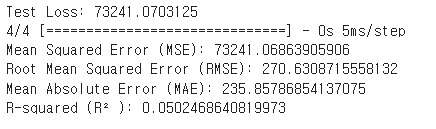

In [ ]:
################# 구조 변경
################# 주의 !!!!!!!!!!!!!!! 새로운 모델을 만드는 것...

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

# 기존 모델(model_saved)의 출력 호출
e_output = model_saved.output

# 새로운 층 추가
new_dense_layer = Dense(128, activation='relu')(e_output)
new_output_layer = Dense(1, activation='linear')(new_dense_layer)

# 새로운 모델 생성
new_model = Model(inputs=model_saved.input, outputs=new_output_layer)

# 새로운 모델 컴파일
new_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
